# Learning on Tangent Data

Lead author: Nicolas Guigui.

In this notebook, we demonstrate how any standard machine learning algorithm can be used on data that live on a manifold yet respecting its geometry. In the previous notebooks we saw that linear operations (mean, linear weighting) don't work on manifold. However, to each point on a manifold, is associated a tangent space, which is a vector space, where all our off-the-shelf ML operations are well defined! 

We will use the [logarithm map](02_from_vector_spaces_to_manifolds.ipynb#From-substraction-to-logarithm-map) to go from points of the manifolds to vectors in the tangent space at a reference point. This will enable to use a simple logistic regression to classify our data.

We import the backend that will be used for geomstats computations and set a seed for reproducibility of the results.

In [1]:
import geomstats.backend as gs

gs.random.seed(2020)

INFO: Using numpy backend


We import the visualization tools.

In [2]:
import matplotlib.pyplot as plt

## The Data

We use data from the [MSLP 2014 Schizophrenia Challenge](https://www.kaggle.com/c/mlsp-2014-mri/data). The dataset correponds to the Functional Connectivity Networks (FCN) extracted from resting-state fMRIs of 86 patients at 28 Regions Of Interest (ROIs). Roughly, an FCN corresponds to a correlation matrix and can be seen as a point on the manifold of Symmetric Positive-Definite (SPD) matrices. Patients are separated in two classes: schizophrenic and control. The goal will be to classify them.

First we load the data (reshaped as matrices):

In [3]:
import geomstats.datasets.utils as data_utils

data, patient_ids, labels = data_utils.load_connectomes()

We plot the first two connectomes from the MSLP dataset with their corresponding labels.

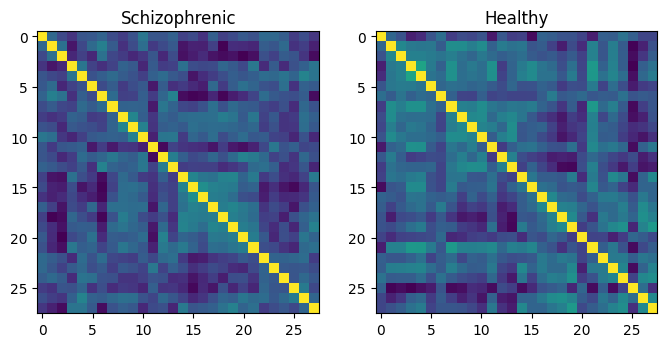

In [4]:
labels_str = ["Healthy", "Schizophrenic"]

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(121)
imgplot = ax.imshow(data[0])
ax.set_title(labels_str[labels[0]])

ax = fig.add_subplot(122)
imgplot = ax.imshow(data[1])
ax.set_title(labels_str[labels[1]])

plt.show()

In order to compare with a standard Euclidean method, we also flatten the data:

In [5]:
flat_data, _, _ = data_utils.load_connectomes(as_vectors=True)
print(flat_data.shape)

(86, 378)


## The Manifold

As mentionned above, correlation matrices are SPD matrices. Because multiple metrics could be used on SPD matrices, we also import two of the most commonly used ones: the Log-Euclidean metric and the Affine-Invariant metric [[PFA2006]](#References). We can use the SPD module from `geomstats` to handle all the geometry, and check that our data indeed belongs to the manifold of SPD matrices:

In [6]:
from geomstats.geometry.spd_matrices import (
    SPDMatrices,
    SPDAffineMetric,
    SPDLogEuclideanMetric,
)

manifold = SPDMatrices(28, equip=False)

spd_ai = SPDMatrices(28, equip=False)
spd_ai.equip_with_metric(SPDAffineMetric)

spd_le = SPDMatrices(28, equip=False)
spd_le.equip_with_metric(SPDLogEuclideanMetric)

print(gs.all(manifold.belongs(data)))

True


## The Transformer

Great! Now, although the sum of two SPD matrices is an SPD matrix, their difference or their linear combination with non-positive weights are not necessarily! Therefore we need to work in a tangent space to perform simple machine learning. But worry not, all the geometry is handled by geomstats, thanks to the preprocessing module.

In [7]:
from geomstats.learning.preprocessing import ToTangentSpace

What `ToTangentSpace` does is simple: it computes the Frechet Mean of the data set (covered in the previous tutorial), then takes the log of each data point from the mean. This results in a set of tangent vectors, and in the case of the SPD manifold, these are simply symmetric matrices. It then squeezes them to a 1d-vector of size `dim = 28 * (28 + 1) / 2`, and thus outputs an array of shape `[n_patients, dim]`, which can be fed to your favorite scikit-learn algorithm.

Because the mean of the input data is computed, `ToTangentSpace` should be used in a pipeline (as e.g. scikit-learn's `StandardScaler`) not to leak information from the test set at train time.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

pipeline = Pipeline(
    steps=[
        ("feature_ext", ToTangentSpace(space=spd_ai)),
        ("classifier", LogisticRegression(C=2)),
    ]
)

We now have all the material to classify connectomes, and we evaluate the model with cross validation. With the affine-invariant metric we obtain:

In [9]:
result = cross_validate(pipeline, data, labels)
print(result["test_score"].mean())

0.7098039215686274


And with the log-Euclidean metric:

In [10]:
pipeline = Pipeline(
    steps=[
        ("feature_ext", ToTangentSpace(space=spd_le)),
        ("classifier", LogisticRegression(C=2)),
    ]
)

result = cross_validate(pipeline, data, labels)
print(result["test_score"].mean())

0.6862745098039216


But wait, why do the results depend on the metric used? You may remember from the previous notebooks that the Riemannian metric defines the notion of geodesics and distance on the manifold. Both notions are used to compute the Frechet Mean and the logarithms, so changing the metric changes the results, and some metrics may be more suitable than others for different applications.

We can finally compare to a standard Euclidean logistic regression on the flattened data:

In [11]:
flat_result = cross_validate(LogisticRegression(), flat_data, labels)
print(flat_result["test_score"].mean())

0.7333333333333334


## Conclusion

In this example using Riemannian geometry does not make a big difference compared to applying logistic regression in the ambiant Euclidean space, but there are published results that show how useful geometry can be with this type of data (e.g [[NDV2014]](#References), [[WAZ2918]](#References)). We saw how to use the representation of points on the manifold as tangent vectors at a reference point to fit any machine learning algorithm, and compared the effect of different metrics on the space of symmetric positive-definite matrices

## References

.. [PFA2006] Pennec, X., Fillard, P. & Ayache, N. A Riemannian Framework for Tensor Computing. Int J Comput Vision 66, 41–66 (2006). https://doi.org/10.1007/s11263-005-3222-z

.. [NDV2014] Bernard Ng, Martin Dressler, Gaël Varoquaux, Jean-Baptiste Poline, Michael Greicius, et al.. Transport on Riemannian Manifold for Functional Connectivity-based Classification. MICCAI - 17th International Conference on Medical Image Computing and Computer Assisted Intervention, Polina Golland, Sep 2014, Boston, United States. hal-01058521

.. [WAZ2918] Wong E., Anderson J.S., Zielinski B.A., Fletcher P.T. (2018) Riemannian Regression and Classification Models of Brain Networks Applied to Autism. In: Wu G., Rekik I., Schirmer M., Chung A., Munsell B. (eds) Connectomics in NeuroImaging. CNI 2018. Lecture Notes in Computer Science, vol 11083. Springer, Cham